In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

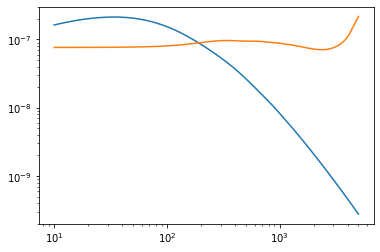

In [3]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [4]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
I_kappa = d_delta_integral(f_KLIM_windowed, f_Kkappa) #[kJy / sr ] [Mpc]

In [5]:
from scipy.integrate import trapezoid, simpson, quad_vec
from scipy.interpolate import interp1d


In [6]:
from tqdm import trange, tqdm

In [7]:
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

In [8]:
chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)

13


In [9]:
Lambdas = np.logspace(-4, -1, 50)

In [10]:
Lambdas = np.logspace(-5, 0, 50)

In [11]:
 np.logspace(-5, 0, 50)[15]

0.000339322177189533

  0%|          | 0/50 [00:00<?, ?it/s]

0.5763910648853134
1e-05


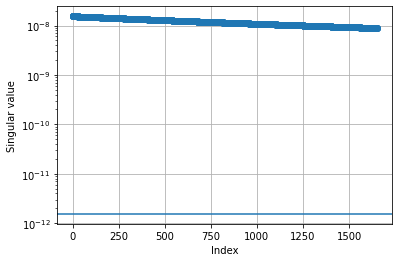

  2%|▏         | 1/50 [00:01<01:09,  1.43s/it]

0.5763895814947154
1.2648552168552958e-05


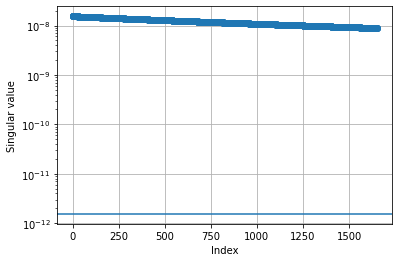

  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

0.5763869691978881
1.5998587196060572e-05


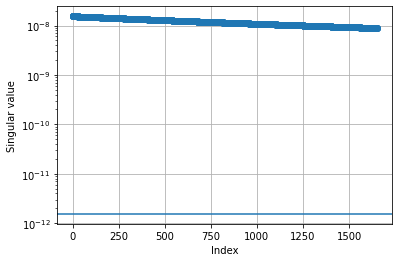

  6%|▌         | 3/50 [00:04<01:08,  1.45s/it]

0.5763821045739962
2.0235896477251556e-05


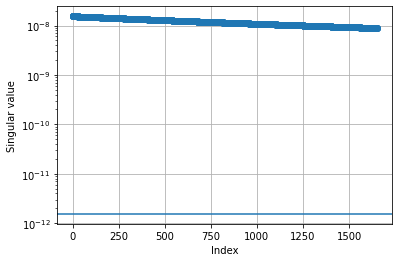

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

0.5763721272776976
2.559547922699533e-05


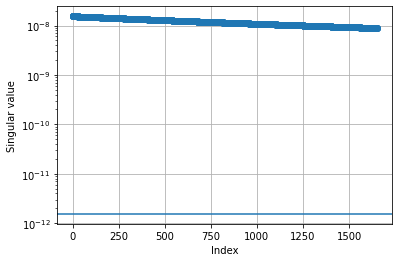

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

0.5763478111040067
3.237457542817647e-05


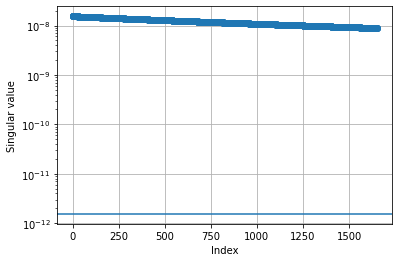

 12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

0.5762690950505355
4.094915062380427e-05


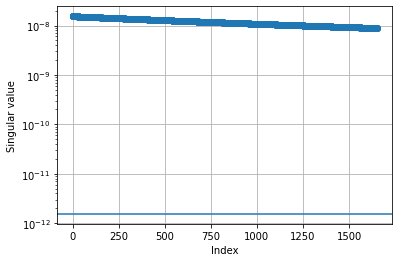

 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it]

0.5759493843080429
5.1794746792312125e-05


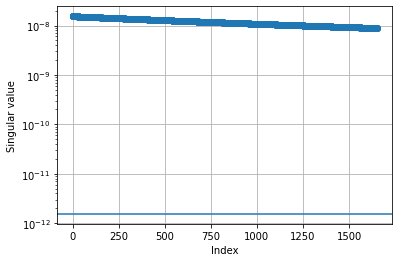

 16%|█▌        | 8/50 [00:11<00:59,  1.43s/it]

0.5748140114661371
6.55128556859551e-05


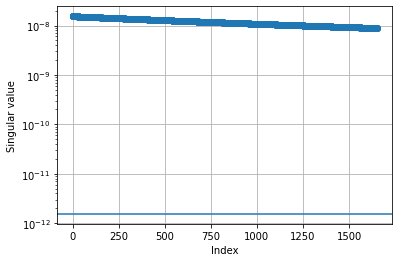

 18%|█▊        | 9/50 [00:13<00:59,  1.46s/it]

0.5717430547477242
8.286427728546843e-05


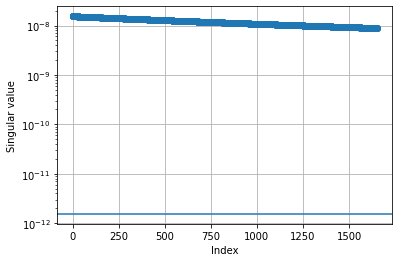

 20%|██        | 10/50 [00:14<00:58,  1.45s/it]

0.5651228324180092
0.00010481131341546853


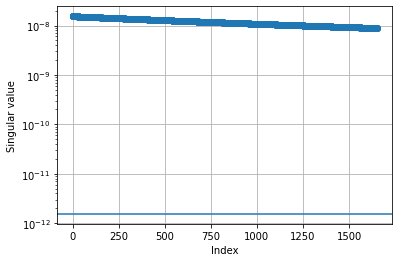

 22%|██▏       | 11/50 [00:15<00:56,  1.45s/it]

0.5530924512240565
0.00013257113655901095


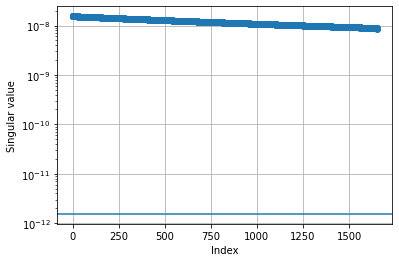

 24%|██▍       | 12/50 [00:17<00:54,  1.44s/it]

0.5338296786839182
0.00016768329368110083


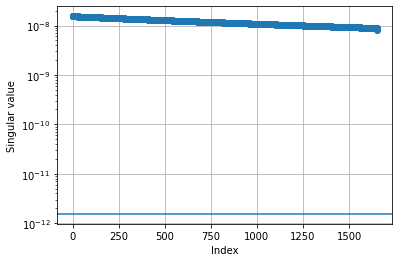

 26%|██▌       | 13/50 [00:18<00:54,  1.47s/it]

0.5057536968053991
0.00021209508879201905


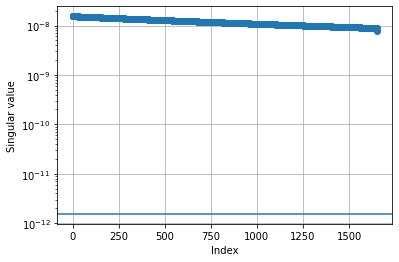

 28%|██▊       | 14/50 [00:20<00:53,  1.47s/it]

0.46766195898819046
0.0002682695795279727


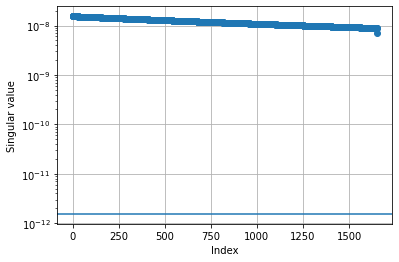

 30%|███       | 15/50 [00:21<00:51,  1.46s/it]

0.4189030014536954
0.000339322177189533


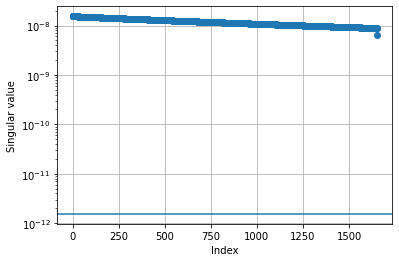

 32%|███▏      | 16/50 [00:23<00:49,  1.45s/it]

0.359695246073283
0.00042919342601287783


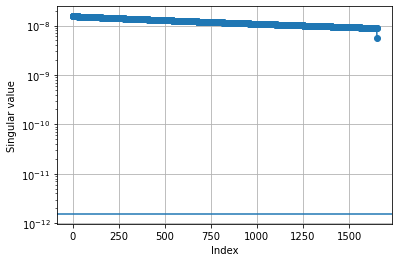

 34%|███▍      | 17/50 [00:24<00:48,  1.48s/it]

0.2916542803142283
0.0005428675439323859


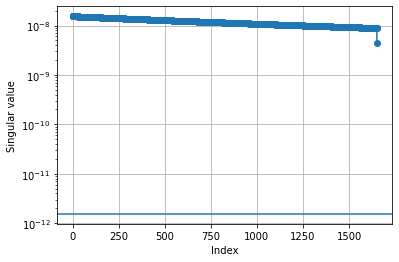

 36%|███▌      | 18/50 [00:26<00:46,  1.47s/it]

0.21846613249934646
0.0006866488450042998


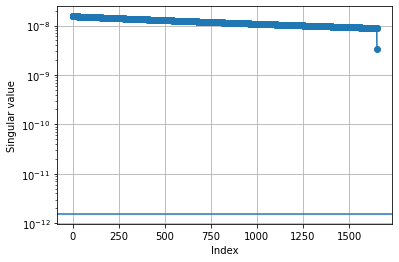

 38%|███▊      | 19/50 [00:27<00:45,  1.47s/it]

0.14636506219400558
0.000868511373751353


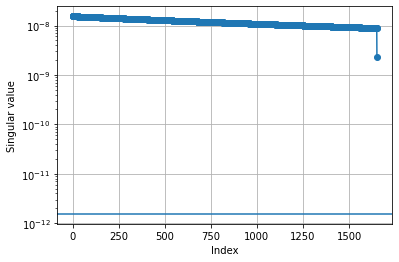

 40%|████      | 20/50 [00:29<00:44,  1.47s/it]

0.0836191096657373
0.0010985411419875584


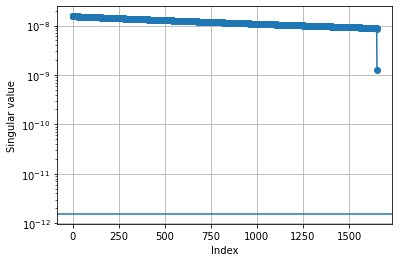

 42%|████▏     | 21/50 [00:30<00:42,  1.45s/it]

0.03799753600205244
0.0013894954943731374


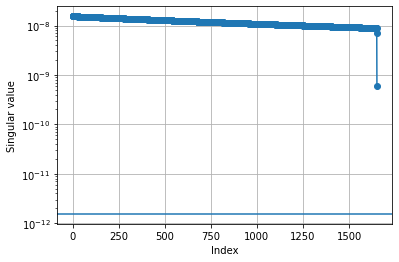

 44%|████▍     | 22/50 [00:31<00:40,  1.43s/it]

0.012446054051490268
0.001757510624854793


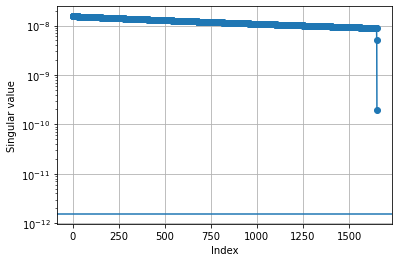

 46%|████▌     | 23/50 [00:33<00:38,  1.42s/it]

0.0025741497250348815
0.0022229964825261957


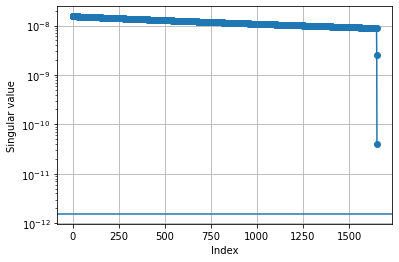

 48%|████▊     | 24/50 [00:34<00:37,  1.43s/it]

0.000280627947972156
0.002811768697974231


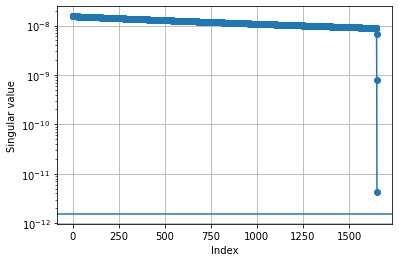

 50%|█████     | 25/50 [00:36<00:35,  1.43s/it]

9.991240753585299e-06
0.0035564803062231283


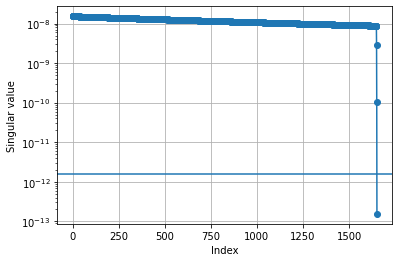

 52%|█████▏    | 26/50 [00:37<00:35,  1.46s/it]

9.190444001444087e-07
0.004498432668969444


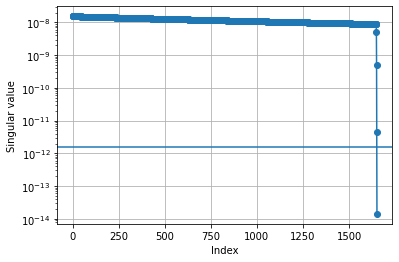

 54%|█████▍    | 27/50 [00:39<00:34,  1.49s/it]

3.1579221812986465e-07
0.005689866029018299


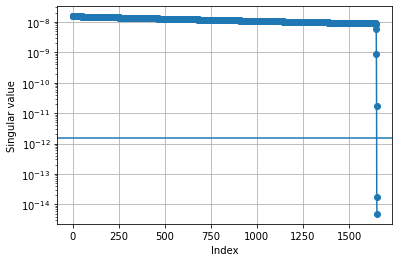

 56%|█████▌    | 28/50 [00:40<00:32,  1.48s/it]

2.9859448714413677e-09
0.0071968567300115215


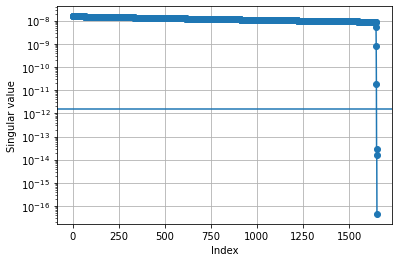

 58%|█████▊    | 29/50 [00:42<00:31,  1.49s/it]

3.580128759061558e-12
0.009102981779915217


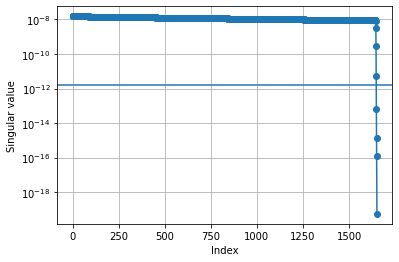

 60%|██████    | 30/50 [00:43<00:29,  1.47s/it]

1.0550330687296222e-16
0.011513953993264481


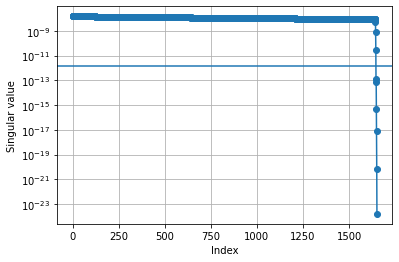

 62%|██████▏   | 31/50 [00:45<00:27,  1.43s/it]

3.0870174873499187e-16
0.014563484775012445


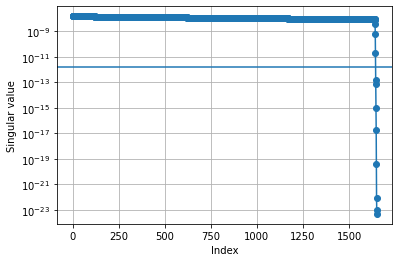

 64%|██████▍   | 32/50 [00:46<00:25,  1.40s/it]

3.124253169364315e-16
0.018420699693267165


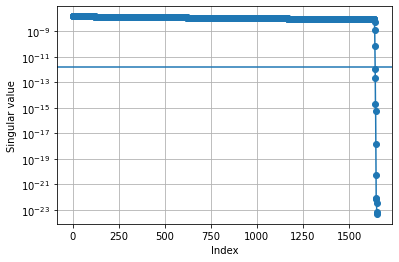

 66%|██████▌   | 33/50 [00:47<00:23,  1.39s/it]

1.3879767652622246e-16
0.023299518105153717


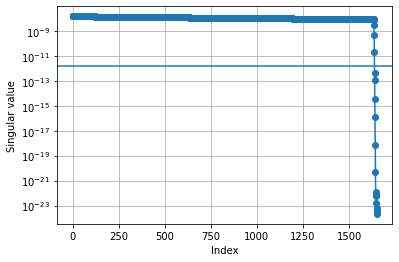

 68%|██████▊   | 34/50 [00:49<00:21,  1.36s/it]

3.848822547162653e-16
0.029470517025518096


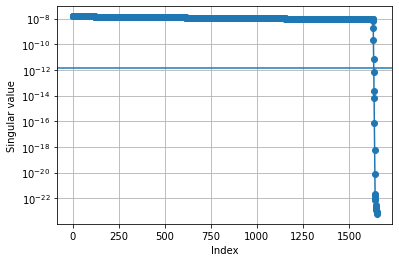

 70%|███████   | 35/50 [00:50<00:20,  1.34s/it]

5.574747919158637e-16
0.037275937203149416


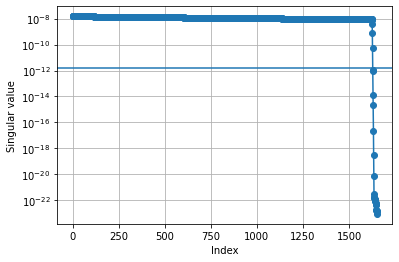

 72%|███████▏  | 36/50 [00:51<00:18,  1.34s/it]

2.4506356376499997e-16
0.04714866363457394


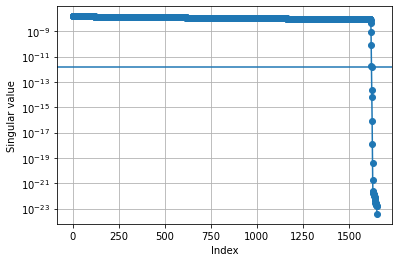

 74%|███████▍  | 37/50 [00:53<00:17,  1.35s/it]

3.3547132236479103e-16
0.05963623316594643


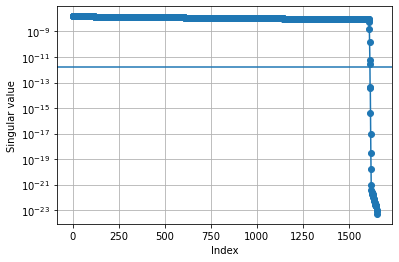

 76%|███████▌  | 38/50 [00:54<00:16,  1.35s/it]

1.8812069423529787e-16
0.07543120063354623


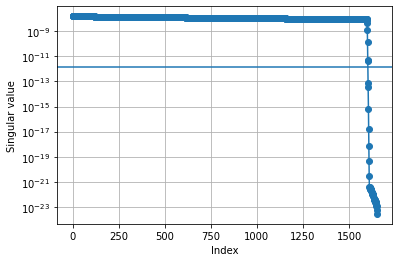

 78%|███████▊  | 39/50 [00:55<00:14,  1.34s/it]

5.027760568935828e-17
0.09540954763499944


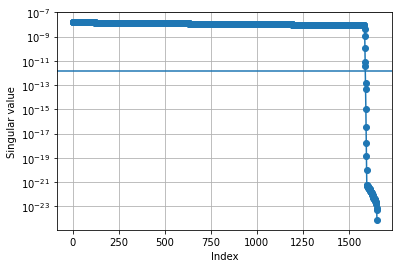

 80%|████████  | 40/50 [00:57<00:13,  1.32s/it]

2.0212796463982964e-16
0.1206792640639329


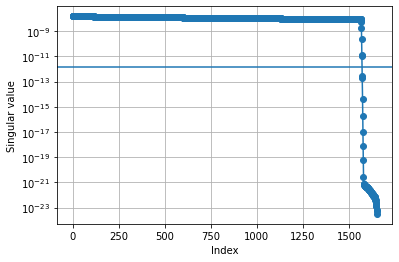

 82%|████████▏ | 41/50 [00:58<00:11,  1.33s/it]

5.605964562158771e-16
0.15264179671752334


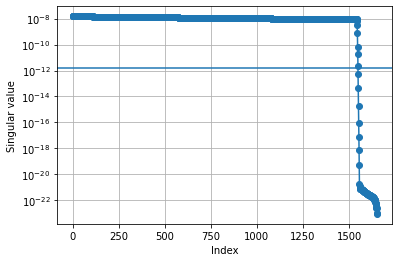

 84%|████████▍ | 42/50 [00:59<00:10,  1.33s/it]

5.941784709921385e-17
0.19306977288832497


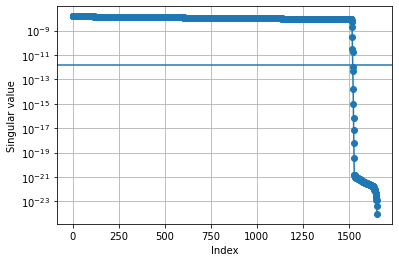

 86%|████████▌ | 43/50 [01:01<00:09,  1.34s/it]

2.885333764483166e-16
0.244205309454865


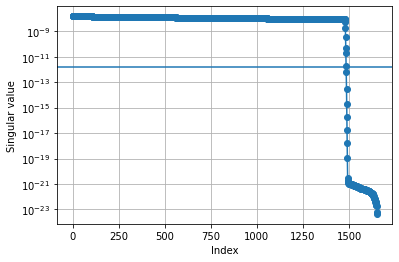

 88%|████████▊ | 44/50 [01:02<00:08,  1.34s/it]

4.2964595565249025e-16
0.30888435964774846


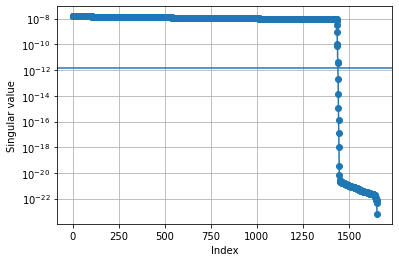

 90%|█████████ | 45/50 [01:03<00:06,  1.32s/it]

5.823607011702583e-16
0.3906939937054621


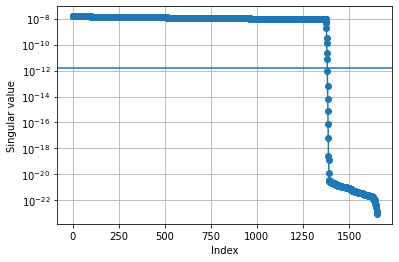

 92%|█████████▏| 46/50 [01:04<00:05,  1.33s/it]

3.9101820002722997e-16
0.49417133613238384


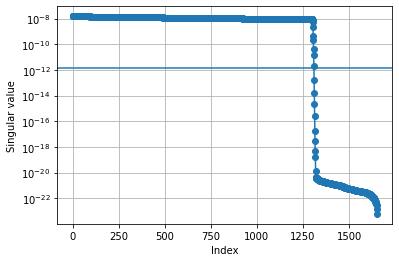

 94%|█████████▍| 47/50 [01:06<00:04,  1.35s/it]

3.9377352589369036e-16
0.6250551925273976


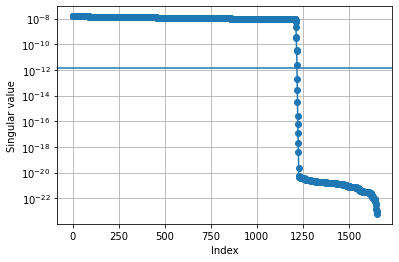

 96%|█████████▌| 48/50 [01:07<00:02,  1.34s/it]

1.031403571455123e-15
0.7906043210907702


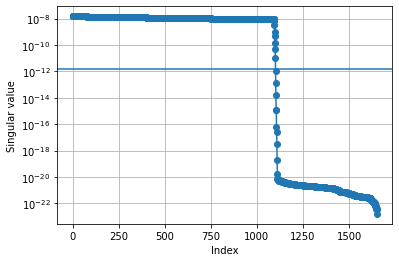

 98%|█████████▊| 49/50 [01:08<00:01,  1.32s/it]

3.2906292568821673e-16
1.0


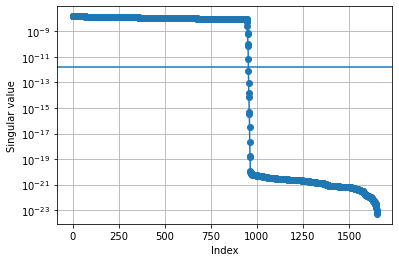

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


In [12]:
SNR2_per_mode = {}
SNR2_per_mode_full = {}
SNR2_per_mode_sanity = {}

integrand =  I_kappa**2 / (1/chis_resample**2)
SNR2_per_mode[0.0] = trapezoid(x = chis_resample, y = integrand)/(ClKK + f_N0(ells)) 
SNR2_per_mode_full[0.0] = SNR2_per_mode[0.0]
SNR2_per_mode_sanity[0.0] = SNR2_per_mode[0.0]

for Lambda in tqdm(Lambdas):
#     if(Lambda > 1e-2):
#         break
#     print(Lambda)
    chis_resample_len = int(np.log2(len(chis_resample)))
    IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
    IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]

    integrand =  IHi_kappa**2 / (1/chis_resample**2) # [kJy^2/sr^2][Mpc^4]
    
    # total integral has unit #[kJy^2 / sr^2][Mpc^3] 
    SNR2_per_mode[Lambda] = simpson(x = chis_resample[window], 
                                    y = integrand[:,window])/(ClKK + f_N0(ells)) 
    

#     eIeI, eLOeLO, eIeLO, eLOeI = get_eHIeHI(chimin, chimax, Lambda)
    oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
    eIeI = np.load(oup_fname + 'eIeI.npy')
    eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
    eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
    eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )

    
    eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI
    IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

    U, s, Vh = np.linalg.svd(eHIeHI, full_matrices=False)
    print(s[-1]/s[0])
    print(Lambda)
    threshold = 1e-4 * s[0] 
    
#     ratios = s[1:]/s[:-1]
#     gaps = np.where(ratios < 0.75)[0]
#     if len(gaps) > 0:
#         threshold = s[gaps[0]]


    plt.semilogy(s, 'o-')
    plt.grid(True)
    plt.xlabel('Index')
    plt.axhline(threshold)
    plt.ylabel('Singular value')
    plt.show()

    s_inv = np.where(s > threshold, 1/s, 0)
    intermediate = (Vh.T * s_inv) @ (U.T @ IHi_kappa_windowed.T)
    SNR2_per_mode_full[Lambda] = np.einsum('ij, ji->i', IHi_kappa_windowed, intermediate)/ (ClKK + f_N0(ells))

    U, s, Vh = np.linalg.svd(eIeI, full_matrices=False)
    threshold = 1e-10 * s[0] 
    s_inv = np.where(s > threshold, 1/s, 0)
    intermediate = (Vh.T * s_inv) @ (U.T @ IHi_kappa_windowed.T)
    SNR2_per_mode_sanity[Lambda] = np.einsum('ij, ji->i',IHi_kappa_windowed, intermediate)/ (ClKK + f_N0(ells))


In [13]:
Lambdas = np.array(sorted(list(SNR2_per_mode.keys())))

In [14]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

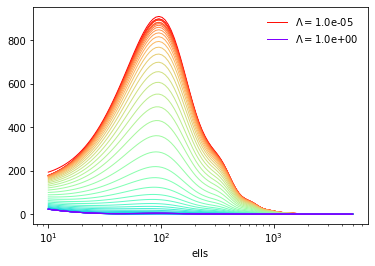

In [15]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

(0.0, 1000.0)

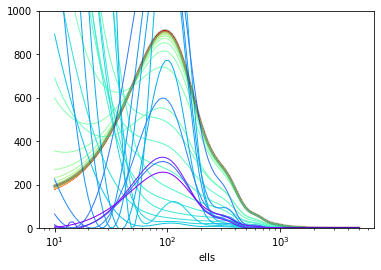

In [16]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode_sanity:
    label = r'$\Lambda=$%.1e'%(Lambda)
    label = None
    plt.plot(ells, SNR2_per_mode_full[Lambda], label=label, lw = 1)
    
plt.plot(ells, SNR2_per_mode[0.0], label=label, lw = 3, c='k', alpha = 0.3)
plt.xscale('log')
plt.xlabel('ells')
plt.ylim(0,1000)

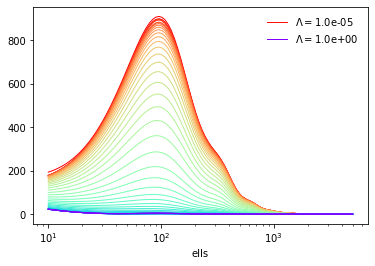

In [17]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode_sanity[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

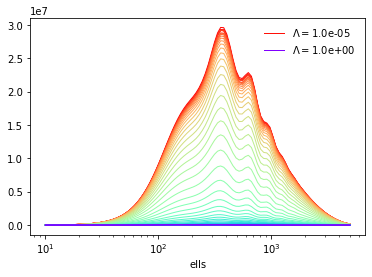

In [18]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

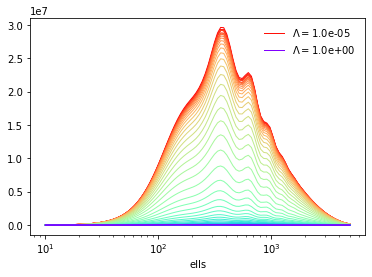

In [19]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_sanity[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

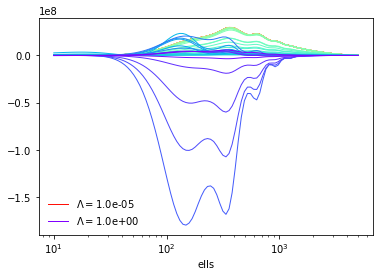

In [20]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [21]:
plt.show()
plt.rcParams['text.usetex'] = True

In [22]:
SNR2_per_Omega_per_invPei = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_full = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_sanity = np.zeros_like(Lambdas)

for Lambda_idx in range(len(Lambdas)):
    Lambda = Lambdas[Lambda_idx]
    #[kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    summand = SNR2_per_mode[Lambda] * ells ** 2 
    
    # [kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    SNR2_per_Omega_per_invPei[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode[Lambda] * ells ** 2 / 2 / np.pi)
    SNR2_per_Omega_per_invPei_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_full[Lambda] * ells ** 2 / 2 / np.pi)
    
    SNR2_per_Omega_per_invPei_sanity[Lambda_idx] = trapezoid(x = np.log(ells), 
                                       y = SNR2_per_mode_sanity[Lambda] * ells ** 2 / 2 / np.pi)

Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

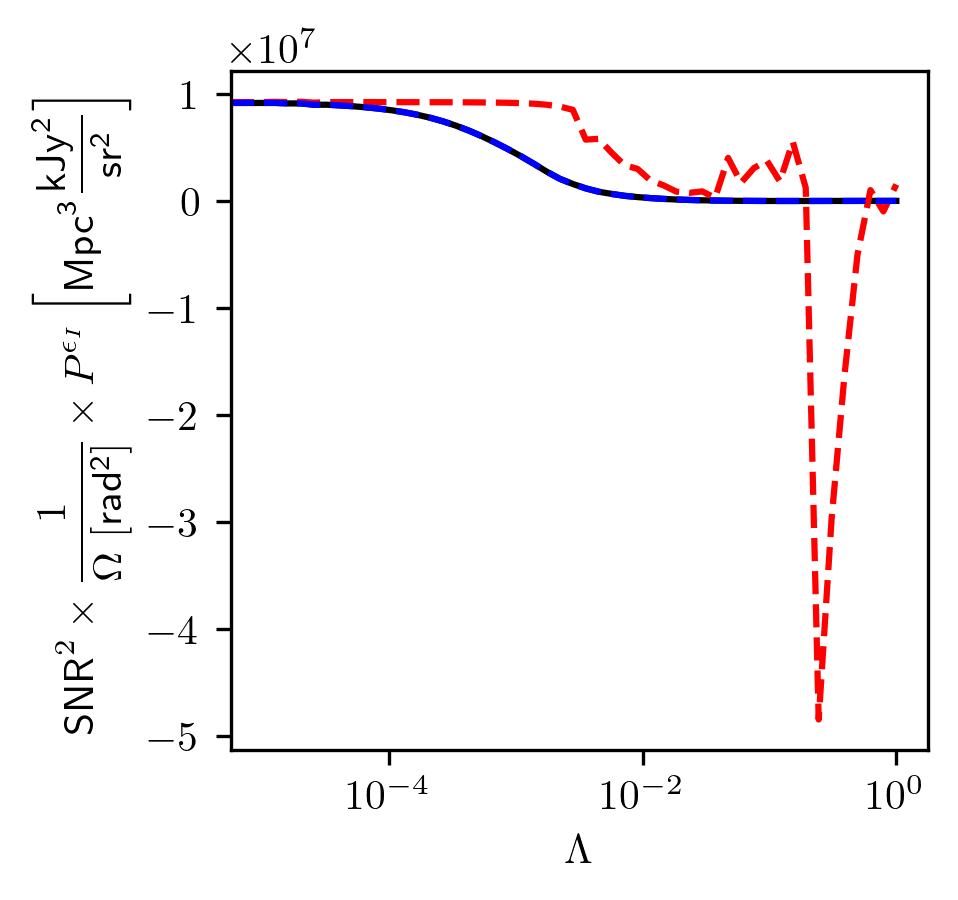

In [23]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, (SNR2_per_Omega_per_invPei), c='k')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_full), 'r--')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_sanity), 'b--')

plt.xscale('log')
fundamental = 2*np.pi/(chimax - chimin)

plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

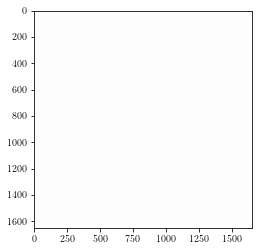

In [24]:
vminmax = np.max(np.abs(eHIeHI))
plt.imshow(eHIeHI, vmin = -vminmax, vmax = vminmax, cmap = 'seismic')

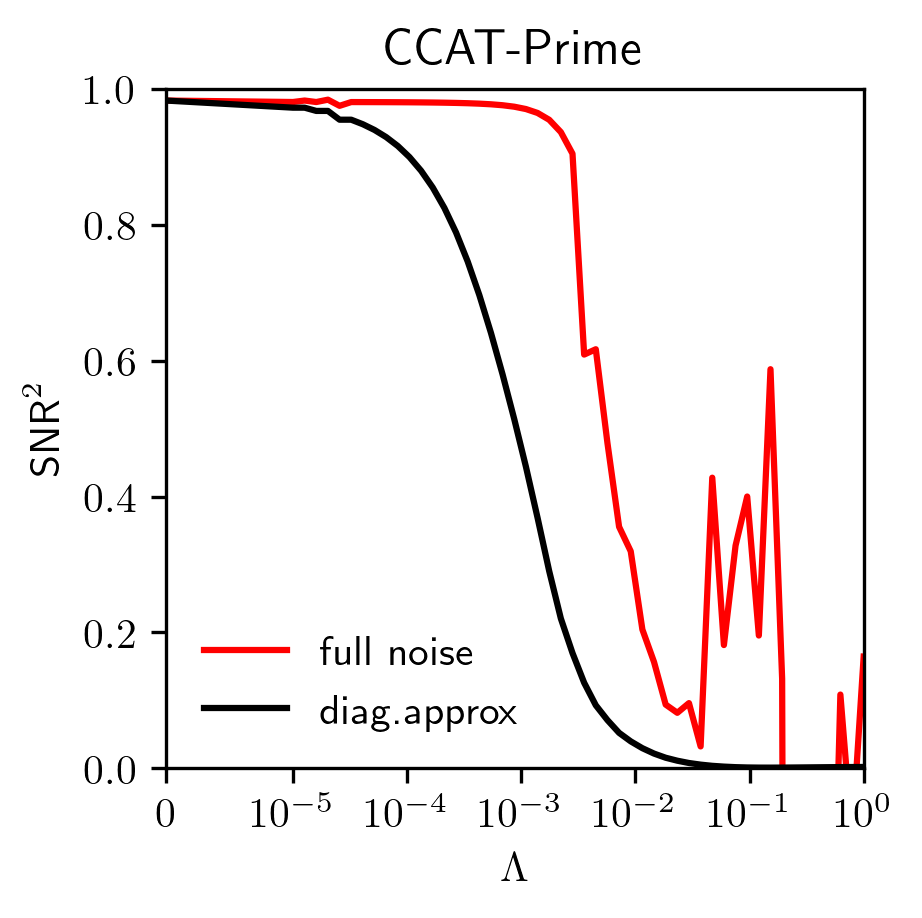

In [27]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         c='k',
        label='diag.approx')

# plt.plot(Lambdas, 
#          (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
#          'b--',
#         label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e0)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')
plt.legend(frameon=False)